In [92]:
# Tratamiento de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluar linealidad de las relaciones entre las variables
# y la distribución de las variables
import scipy.stats as stats
from scipy.stats import chi2_contingency, ttest_ind

# Configuración
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames


# Gestión de los warnings
import warnings
warnings.filterwarnings("ignore")

In [93]:
df = pd.read_csv("../../files/df_nulos_imputados.csv", index_col=0)

Revisamos las tres columnas de satisfacción y sus medias/medianas

In [94]:
df[['EnvironmentSatisfaction' , 'JobSatisfaction' , 'RelationshipSatisfaction']].agg(['mean' , 'median'])

,EnvironmentSatisfaction,JobSatisfaction,RelationshipSatisfaction
mean,1.104287,2.730646,2.714012
median,1.000000,3.000000,3.000000


Observamos que las encuestas de environment satisfaction son muy bajas en comparación con job y relationship satisfaction, lo cual puede impactar en la media resultante. Por tanto, decidimos hacer una media ponderada y darle un peso determinado a cada una de las variables para tratar de mitigar dicho impacto:

**Distribución de pesos**
- EnvironmentSatisfaction: 20%
- JobSatisfaction: 40%
- RelationshipSatisfaction: 40%

Creamos la columna de Overall Satisfaction haciendo la media ponderada

In [95]:
# Definimos los pesos
weights = {
    'EnvironmentSatisfaction': 0.20,
    'JobSatisfaction': 0.40,
    'RelationshipSatisfaction': 0.40
}

# Calculamos la media ponderada
df['OverallSatisfaction'] = round(
    df['EnvironmentSatisfaction'] * weights['EnvironmentSatisfaction'] +
    df['JobSatisfaction'] * weights['JobSatisfaction'] +
    df['RelationshipSatisfaction'] * weights['RelationshipSatisfaction']
, 0)

# Convertimos los resultados a integer
df['OverallSatisfaction'] = df['OverallSatisfaction'].astype('int64')

Creamos la columna de satisfacción en base al Overall Satisfaction

In [96]:
df['TestGroup'] = df['OverallSatisfaction'].apply(lambda x : 'satisfechos' if x >= 3 else 'insatisfechos')

Hacemos una tabla de contingencia y analizamos los datos

In [97]:
tabla_contingencia_porcentaje = pd.crosstab(df['TestGroup'], df['Attrition'], normalize = True) * 100
tabla_contingencia = pd.crosstab(df['TestGroup'], df['Attrition']) 
tabla_contingencia

Attrition,No,Yes
TestGroup,,
insatisfechos,638,144
satisfechos,673,108


In [109]:
tabla_contingencia_porcentaje

Attrition,No,Yes
TestGroup,,
insatisfechos,40.818938,9.213052
satisfechos,43.058221,6.909789


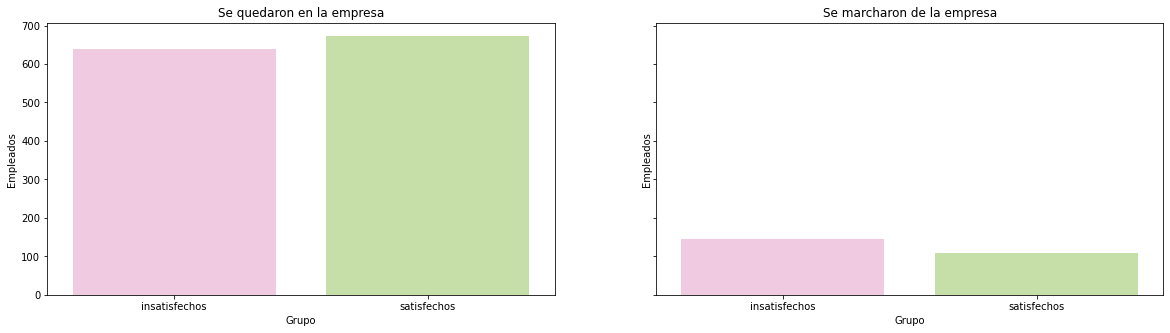

In [98]:
# hacemos un análisis visual previo
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 5), sharey=True)

sns.barplot(x=tabla_contingencia.index, y="No", data=tabla_contingencia,  palette = "PiYG", ax = axes[0])
sns.barplot(x=tabla_contingencia.index, y="Yes", data=tabla_contingencia,  palette = "PiYG", ax = axes[1])

axes[0].set_title("Se quedaron en la empresa")
axes[1].set_title("Se marcharon de la empresa")

axes[0].set_xlabel("Grupo")
axes[0].set_ylabel("Empleados")

axes[1].set_xlabel("Grupo")
axes[1].set_ylabel("Empleados");

In [99]:
# Realizar la prueba de proporciones
chi2, p_value, _, _ = chi2_contingency(tabla_contingencia)

# Imprimir el resultado de la prueba
alpha = 0.05
if p_value < alpha:
    print(f"Con un p_value de {p_value} hay una diferencia significativa en la cantidad de attrition según el grupo")
else:
    print(f"Con un p_value de {p_value} no hay una diferencia significativa en la cantidad de attrition según el grupo")

Con un p_value de 0.01656162686117298 hay una diferencia significativa en la cantidad de attrition según el grupo


Revisamos las columnas de satisfacción por separado

In [100]:
df2 = df.copy()

In [101]:
df2['Test_Env'] = df2['EnvironmentSatisfaction'].apply(lambda x : 'satisfechos' if x >= 3 else 'insatisfechos')

In [102]:
tabla_contingencia2 = pd.crosstab(df2['Test_Env'], df2['Attrition']) 

Attrition,No,Yes
Test_Env,,
insatisfechos,1264,248
satisfechos,47,4


In [103]:
# Calcular el porcentaje para 'No' en cada fila
tabla_contingencia2['No %'] = tabla_contingencia2['No'] / (tabla_contingencia2['No'] + tabla_contingencia2['Yes']) * 100

# Usar los valores originales de 'Yes' para calcular el porcentaje en cada fila
tabla_contingencia2['Yes %'] = tabla_contingencia2['Yes'] / (tabla_contingencia2['No'] + tabla_contingencia2['Yes']) * 100

# Mostrar el DataFrame actualizado
tabla_contingencia2.drop(['No' , 'Yes'], inplace = True, axis = 1)

In [105]:
tabla_contingencia2

Attrition,No %,Yes %
Test_Env,,
insatisfechos,83.597884,16.402116
satisfechos,92.156863,7.843137


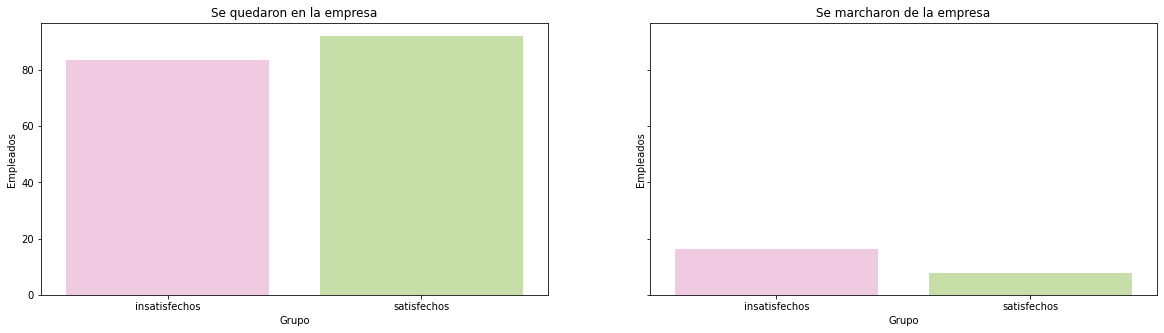

In [108]:
# hacemos un análisis visual previo
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 5), sharey=True)

sns.barplot(x=tabla_contingencia2.index, y="No %", data=tabla_contingencia2,  palette = "PiYG", ax = axes[0])
sns.barplot(x=tabla_contingencia2.index, y="Yes %", data=tabla_contingencia2,  palette = "PiYG", ax = axes[1])

axes[0].set_title("Se quedaron en la empresa")
axes[1].set_title("Se marcharon de la empresa")

axes[0].set_xlabel("Grupo")
axes[0].set_ylabel("Empleados")

axes[1].set_xlabel("Grupo")
axes[1].set_ylabel("Empleados");